# Finding Palomar 5's tidal tail in SDSS photometry

In [1]:
import vaex as vx
import numpy as np
import matplotlib.pylab as plt
import scipy.ndimage.filters
from astropy.coordinates import SkyCoord
import numpy as np
import xarray as xr

%matplotlib inline

# alias for gaussian filter
gf = scipy.ndimage.filters.gaussian_filter

## Model
Our signal (a color magnitude or Hess diagram) in each pixel on the sky is represented by a vector $\vec{x}$, and is a sum of the background template $\vec{b}$ (Milky Way stars) and a Palomar 5 template $\vec{t}$:
 * $\vec{x} = \alpha\vec{t} + (n-\alpha)\vec{b}$
 * $n = \sum \vec{x}_i$ (total number of stars in each pixel)
 * $\alpha$ (total number of stars that match the template)
 
Solve for $\alpha$ by multiplying by $\vec{t}$:
 * $\vec{t}\vec{x} = \alpha\vec{t}\vec{t} + (n-\alpha)\vec{t}\vec{b}$
 * $\vec{t}\vec{x} = \alpha(\vec{t}\vec{t} - \vec{t}\vec{b}) + n\vec{t}\vec{b}$
 * $\alpha = \frac{\vec{t}\vec{x} - n\vec{t}\vec{b}}{\vec{t}\vec{t} - \vec{t}\vec{b}}$
 
A different solution is to used the 'Matched filter' technique, as in [Rockosi et al. 2002](http://stacks.iop.org/1538-3881/124/i=1/a=349), which leads to
 * $\alpha = \sum_{i,j} (x_{i,j}\frac{t_{i,j}}{n b_{i,j}} - t_{i,j}) /  \sum_{i,j} \frac{t_{i,j}^2}{n b_{i,j}}  $

## Data

The data is downloaded from the SDSS archive, with the effective query:
```
SELECT ra, dec, g, r from PhotoObjAll WHERE type = 6 and  clean = 1 and r>=10.0 and r<23.5;
```

After this step we do a reddening correction using the Schlegel extinction map (TODO: publish this code, it's using this http://adsabs.harvard.edu/abs/2013MNRAS.430.2188Y). 

The data can we downloaded from [Google Drive](https://drive.google.com/file/d/0B8gjQokMGa4nUlRnZFlXSlZXOTQ/view?usp=sharing)



In [2]:
ds = vx.open("sdss_dereddened.hdf5")
# create nice aliases to Alpha and Delta
ds.add_virtual_column("ra", ds.col.Alpha)
ds.add_virtual_column("dec", ds.col.Delta)

## Setup
We construct a template CMD from the Pal5 data in the SDSS catalogue, and a background CMD from a neighbouring area.

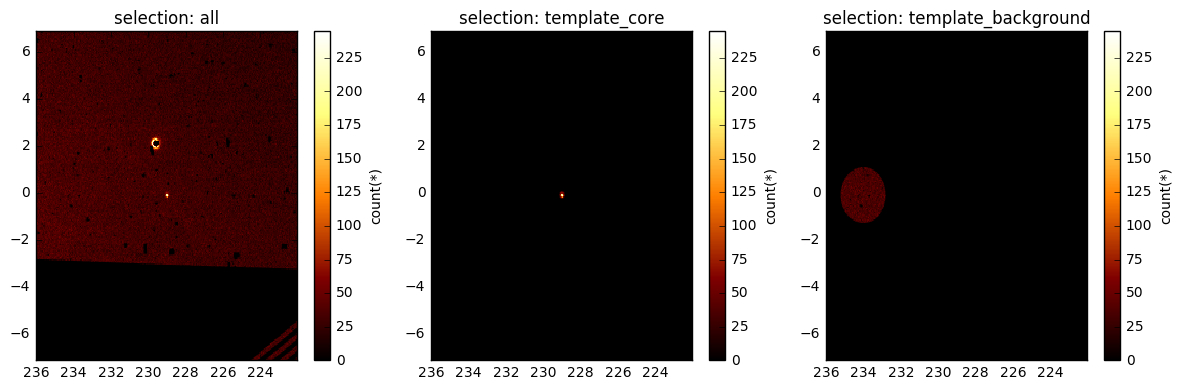

In [3]:
# define a selection for the Pal5 cmd
from astropy import units as u
coordinate_pal5 = SkyCoord.from_name("Palomar 5")
pal5_ra, pal5_dec = coordinate_pal5.ra.degree, coordinate_pal5.dec.degree
template_ra, template_dec = pal5_ra, pal5_dec
ds.add_variable("template_ra", template_ra)
ds.add_variable("template_dec", template_dec)
ds.select("(ra - template_ra)**2 + (dec - template_dec) ** 2 < 0.15**2", name="template_core")
ds.select("(ra - template_ra-5)**2 + (dec - template_dec) ** 2 < 1.20**2", name="template_background")
# visualize the areas we use for the selections
ds.plot("ra", "dec", selection=[None, "template_core", "template_background"],
       limits=[[pal5_ra+7, pal5_ra-7], [pal5_dec-7, pal5_dec+7]], visual=dict(row="selection"), figsize=(12,4))

In [4]:
# smoothing in pixel space for CMD
sigma_cmd = (1, 1)

# define the shapes for the grids, the limits and the expressions to use
sky_shape = (256,256)
cmd_shape = (24,24)

binby_cmd = ["g_r", "sdss_g"] # g_r is g-r and deredenned
limits_cmd = [[-0.2, 1], [22.0,15]]

size_pal5 = 17 # degrees around pal5
limits_pal5 = [[pal5_ra+size_pal5, pal5_ra-size_pal5], [pal5_dec-size_pal5, pal5_dec+size_pal5]]

limits_sky = limits_pal5
binby_sky = ["ra", "dec"]


We now define the model template, the background template and the data vector. We convert the numpy arrays to xarray arrays to keep track of the dimensions.

In [5]:
# t is a 2d array (color, magnitude) which represents a (normalized) template Pal5 CMD
cmd_template = ds.count(binby=binby_cmd, limits=limits_cmd, shape=(24,24), selection="template_core")
cmd_template = gf(cmd_template, sigma_cmd) # smooth a bit
t = xr.DataArray(cmd_template / cmd_template.sum(), dims=["color", "magnitude"] )

# t is a 2d array (color, magnitude) which represents a (normalized) template Milky Way foreground/background CMD
cmd_background = ds.count(binby=binby_cmd, limits=limits_cmd, shape=(24,24), selection="template_background")
cmd_background = gf(cmd_background, sigma_cmd)
b_template = xr.DataArray(cmd_background / cmd_background.sum(), dims=["color", "magnitude"] )

# x is a 4d array (ra, dec, color, magnitude) which holds the CMD for each pixel on the sky, not normalized
sky_cmd = ds.count(binby=binby_sky + binby_cmd, limits=limits_sky + limits_cmd, shape=sky_shape + cmd_shape)
x = xr.DataArray(sky_cmd, dims=["long", "lat", "color", "magnitude"])

# n is a 2d array which keeps the number of stars in the CMD range for each pixels on the sky
n = x.sum(dim=["color", "magnitude"]) # using xarray we can refer to dimension names, instead of axis numbers

Visualize the area on the sky, and the CMD templates

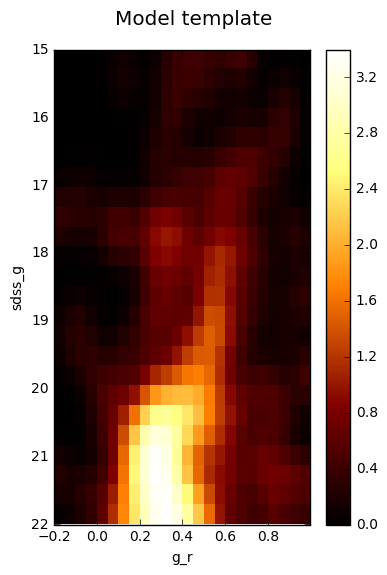

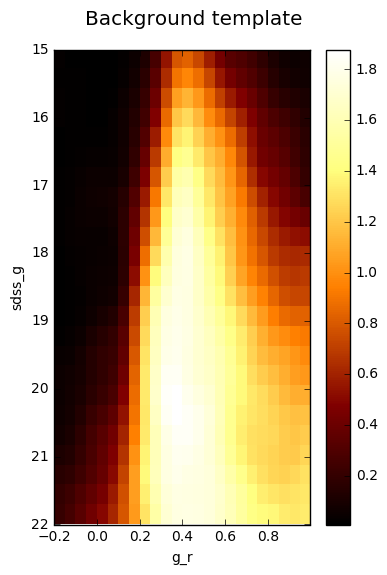

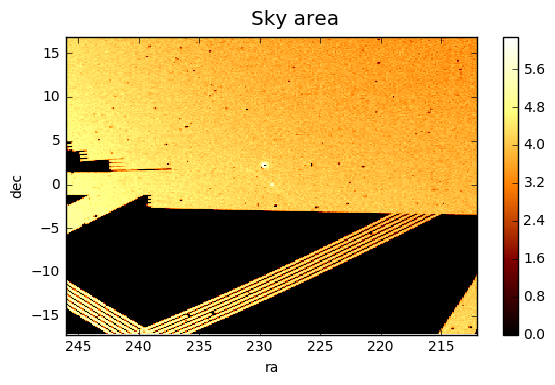

In [6]:
ds.plot(*binby_cmd, grid=t*1000, limits=limits_cmd, f="log1p", figsize=(4,6),show=True, title="Model template")
ds.plot(*binby_cmd, grid=b_template*1000, limits=limits_cmd, f="log1p", figsize=(4,6),show=True, title="Background template")
ds.plot(*binby_sky, grid=n, limits=limits_sky, f="log1p", show=True, title="Sky area")

## Solution 1: Palomer 5
Now we solve the equations above using to estimate how many Palomar 5 stars are in each pixel on the sky.

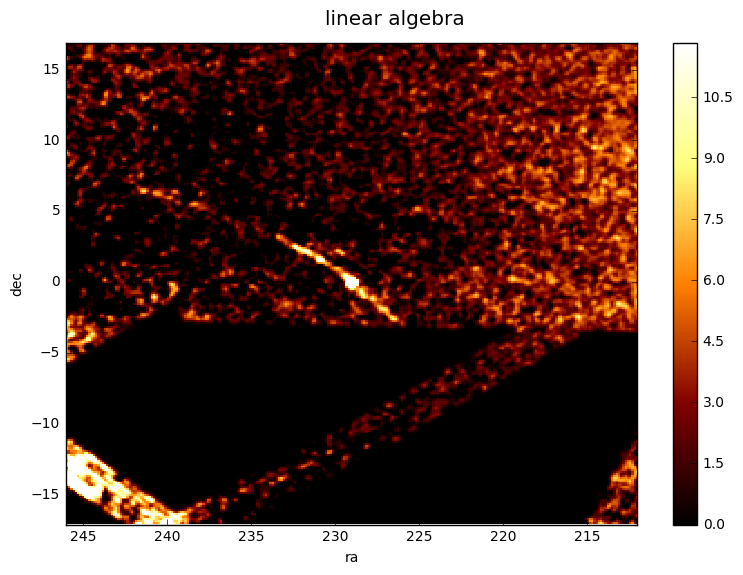

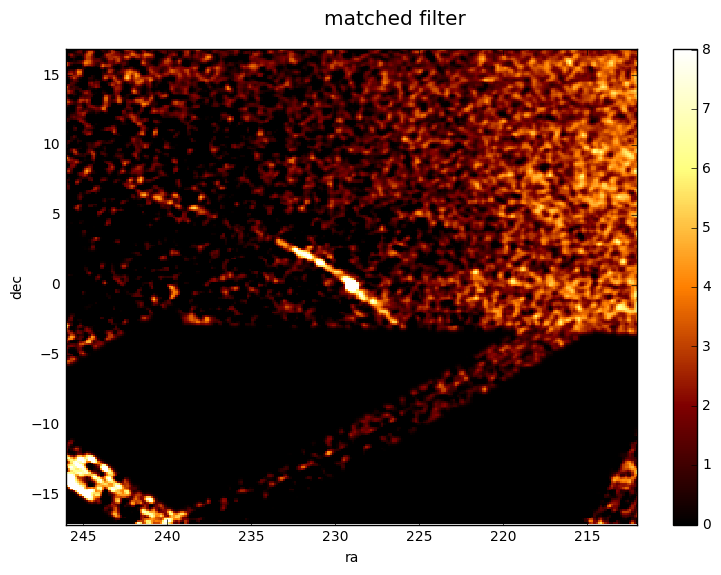

In [7]:
b = b_template
# Solve using linear algebra
alpha_LA = (x.dot(t) - n * t.dot(b)) / (t.dot(t) - t.dot(b))
# Or matched filter method by Rockosi et al. 2002
alpha_MF = (x * t / (n*b) - t).sum(dim=["magnitude", "color"]) / (t**2/(n*b)).sum(["magnitude", "color"])

for alpha, method in [(alpha_LA, "linear algebra"), (alpha_MF, "matched filter")]:
    alpha = alpha.data # work with the normal numpy array instead of xarray 
    vmax = np.percentile(alpha[np.isfinite(alpha)], 97) # increase contrast
    ds.plot(*binby_sky, grid=alpha, limits=limits_sky, vmin=0, vmax=vmax,
            title=method,
            figsize=(8,6), smooth_pre=1)
    plt.show()

The methods qualitatively give similar results. The linear algebra methods is conceptually simpler and seems to find a higher signal, but the matched filter technique should theoretically give a higher signal to noise.

## Solution 2: Better background
In the right corner, the background model seems to fail. Now we construct a background model for each pixel, by convolving the CMD's with eachother locally.

In [8]:
# normalize each cmd on the sky so that high density region's cmds don't weight in more
cmds = (x / n).data
# where divided by zero, just put to 0, so it doesn't add to the filtering step
cmds[np.isnan(cmds)] = 0
# filter it
cmds_smooth = gf(cmds, (20, 20) + sigma_cmd)

b = b_sky = xr.DataArray(cmds_smooth, dims=["long", "lat", "color", "magnitude"])
# and normalize again
b /= b.sum(dim=["color", "magnitude"])
b.data[n.data==0] = 0

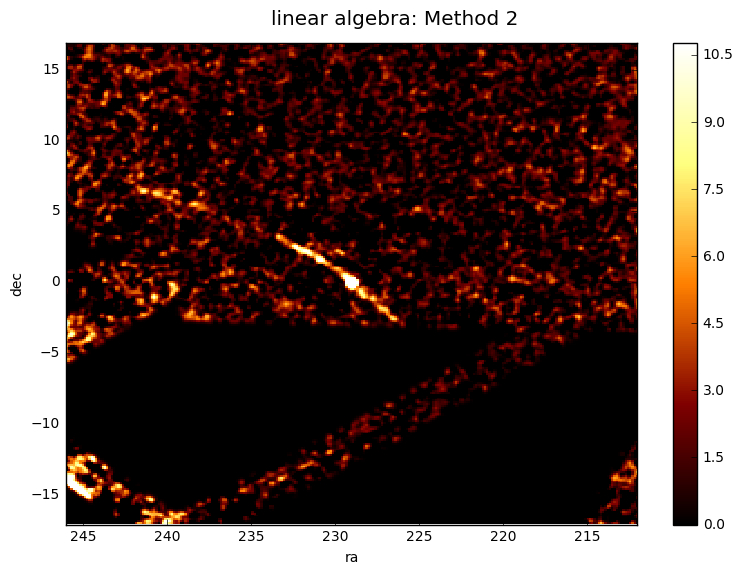

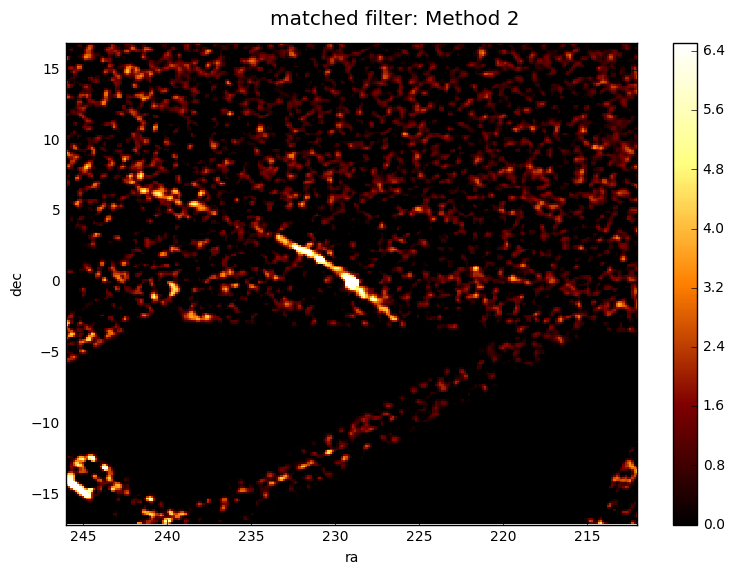

In [9]:
# Solve using linear algebra, with the per pixel CMD background
alpha_LA2 = (x.dot(t) - n * t.dot(b)) / (t.dot(t) - t.dot(b))
# Or matched filter method by Rockosi et al. 2002
alpha_MF = (x * t / (n*b) - t).sum(dim=["magnitude", "color"]) / (t**2/(n*b)).sum(["magnitude", "color"])

for alpha, method in [(alpha_LA2, "linear algebra: Method 2"), (alpha_MF, "matched filter: Method 2")]:
    alpha = alpha.data # work with the normal numpy array instead of xarray 
    vmax = np.percentile(alpha[np.isfinite(alpha)], 97) # increase contrast
    ds.plot(*binby_sky, grid=alpha, limits=limits_sky, vmin=0, vmax=vmax,
            title=method,
            figsize=(8,6), smooth_pre=1)
    plt.show()